# install & docs

https://github.com/arogozhnikov/einops

`pip install einops`

einops 支持 **numpy, pytorch, tensorflow, keras, jax** 等

einops所有操作的pattern的axis之间必须有空格

```python
einops.einsum
    "i j, k j -> i k" ✅
    "i j, k j -> ik"  ❌

einops.rearrange
    "t (b c) -> b c t" ✅
    "t (b c) -> b ct"  ❌
```


In [43]:
import numpy as np
import torch
from einops import einsum, rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import matplotlib.pyplot as plt
from PIL import Image
np.random.seed(0)
torch.manual_seed(0)

# einsum same as torch.einsum

In [2]:
a = np.random.random((1, 196, 768))
b = np.random.random((1, 768, 196))

In [3]:
a_t = torch.from_numpy(a)
b_t = torch.from_numpy(b)

## 不需要转置

In [4]:
c0 = np.einsum("b p c, b c k -> b p k", a, b)
c0.shape

(1, 196, 196)

In [5]:
c1 = einsum(a, b, "b p c, b c k -> b p k")
c1.shape

(1, 196, 196)

In [6]:
np.all(c0==c1)

True

In [7]:
c0_t = torch.einsum("b p c, b c k -> b p k", a_t, b_t)    # 空格可有可无
c0_t.shape

torch.Size([1, 196, 196])

In [8]:
c1_t = einsum(a_t, b_t, "b p c, b c k -> b p k")          # einops所有操作的pattern的axis之间必须有空格
c1_t.shape

torch.Size([1, 196, 196])

In [9]:
torch.all(c0_t==c1_t)

tensor(True)

## 需要转置

In [10]:
c2 = np.einsum("b p c, b k c -> b p k", a, b.swapaxes(1, 2))
c2.shape

(1, 196, 196)

In [11]:
c3 = einsum(a, b.swapaxes(1, 2), "b p c, b k c -> b p k")
c3.shape

(1, 196, 196)

In [12]:
np.all(c0==c1), np.all(c1==c2), np.all(c2==c3)

(True, True, True)

In [13]:
c2_t = torch.einsum("b p c, b k c -> b p k", a_t, b_t.transpose(1, 2))
c2_t.shape

torch.Size([1, 196, 196])

In [14]:
c3_t = einsum(a_t, b_t.transpose(1, 2), "b p c, b k c -> b p k")
c3_t.shape

torch.Size([1, 196, 196])

In [15]:
torch.all(c0_t==c1_t), torch.all(c1_t==c2_t), torch.all(c2_t==c3_t)

(tensor(True), tensor(True), tensor(True))

# rearrange: reshape, transopse, permute

In [16]:
input_tensor = np.ones((196, 10, 768))
# rearrange elements according to the pattern
rearrange(input_tensor, "t b c -> b c t").shape   # einops所有操作的pattern的axis之间必须有空格

(10, 768, 196)

In [17]:
input_tensor = torch.ones((196, 10, 768))
# rearrange elements according to the pattern
output_tensor0 = rearrange(input_tensor, "t b c -> b c t")   # einops所有操作的pattern的axis之间必须有空格
output_tensor0.shape

torch.Size([10, 768, 196])

In [18]:
rearrange_ = Rearrange("t b c -> b c t")
# rearrange elements according to the pattern
output_tensor1 = rearrange_(input_tensor)
output_tensor1.shape

torch.Size([10, 768, 196])

In [19]:
torch.all(output_tensor0==output_tensor1)

tensor(True)

In [20]:
input_tensor = torch.ones((196, 10*768))
# () 代表隐藏维度,需要指定内部值,不需要全部指定,可以推导出即可
output_tensor2 = rearrange(input_tensor, "t (b c) -> b c t", b=10)  # einops所有操作的pattern的axis之间必须有空格
output_tensor2.shape

torch.Size([10, 768, 196])

In [21]:
torch.all(output_tensor0==output_tensor2)

tensor(True)

## 变量使用多个字母

In [22]:
input_tensor = np.ones((1, 196, 3*768))
output_tensor = rearrange(input_tensor, "b n (qkv h d) -> qkv b h n d", qkv = 3, h = 12)    # 不使用空格会当做单个变量
output_tensor.shape

(3, 1, 12, 196, 64)

In [23]:
input_tensor = torch.ones((1, 196, 3*768))
output_tensor0 = rearrange(input_tensor, "b n (qkv h d) -> qkv b h n d", qkv = 3, h = 12)    # 不使用空格会当做单个变量
output_tensor0.shape

torch.Size([3, 1, 12, 196, 64])

In [24]:
output_tensor1 = input_tensor.reshape(1, 196, 3, 12, -1).permute(2, 0, 3, 1, 4)
output_tensor1.shape

torch.Size([3, 1, 12, 196, 64])

In [25]:
torch.all(output_tensor0==output_tensor1)

tensor(True)

# reduce: rearrange + min/max/sum/mean/prod

In [26]:
x = np.random.randn(100, 32, 64)
x.shape

(100, 32, 64)

In [27]:
# perform max-reduction on the first axis
reduce(x, 't b c -> b c', 'max').shape

(32, 64)

In [28]:
# same as previous, but with clearer axes meaning
reduce(x, 'time batch channel -> batch channel', 'max').shape

(32, 64)

In [29]:
x = np.random.randn(10, 20, 30, 40)
x.shape

(10, 20, 30, 40)

In [30]:
# 2d max-pooling with kernel size = 2 * 2 for image processing
y1 = reduce(x, 'b c (h1 h2) (w1 w2) -> b c h1 w1', 'max', h2=2, w2=2)
y1.shape

(10, 20, 15, 20)

In [31]:
# if one wants to go back to the original height and width, depth-to-space trick can be applied
# 将 c 转换到 h w
y2 = rearrange(y1, 'b (c h2 w2) h1 w1 -> b c (h1 h2) (w1 w2)', h2=2, w2=2)
y2.shape

(10, 5, 30, 40)

In [32]:
# Adaptive 2d max-pooling to 3 * 4 grid
reduce(x, 'b c (h1 h2) (w1 w2) -> b c h1 w1', 'max', h1=3, w1=4).shape

(10, 20, 3, 4)

In [33]:
# Global average pooling
reduce(x, 'b c h w -> b c', 'mean').shape

(10, 20)

In [34]:
# Subtracting mean over batch for each channel
print(reduce(x, 'b c h w -> () c () ()', 'mean').shape)
print(reduce(x, 'b c h w -> 1 c 1 1', 'mean').shape)    # 1 same as ()
print((x - reduce(x, 'b c h w -> () c () ()', 'mean')).shape)

(1, 20, 1, 1)
(1, 20, 1, 1)
(10, 20, 30, 40)


In [35]:
# Subtracting per-image mean for each channel
print(reduce(x, 'b c h w -> b c () ()', 'mean').shape)
print((x - reduce(x, 'b c h w -> b c () ()', 'mean')).shape)

(10, 20, 1, 1)
(10, 20, 30, 40)


# repeat: repeat, expand

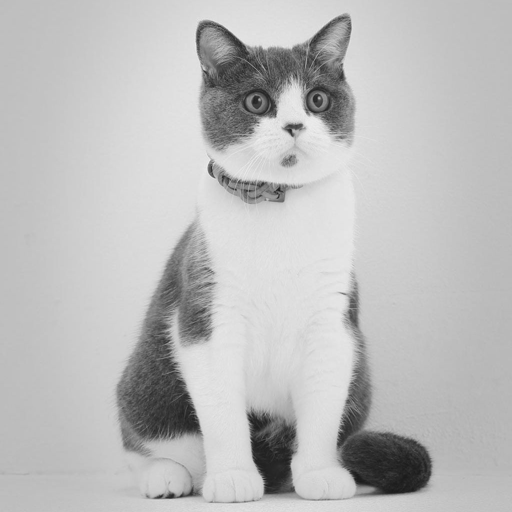

In [50]:
# a grayscale image (of shape height x width)
image = Image.open("cat4.jpg").resize((512, 512)).convert('L')
image

(512, 512, 3)


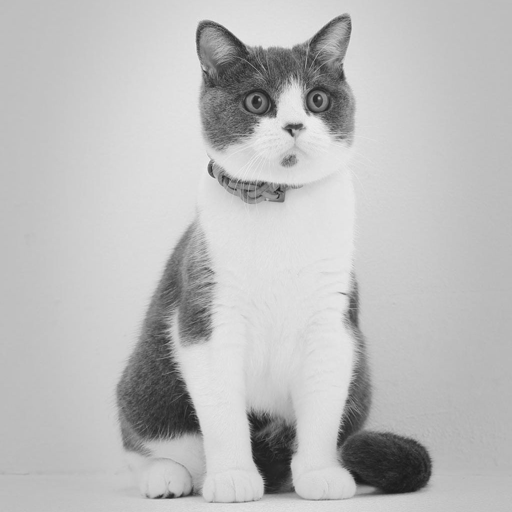

In [55]:
# change it to RGB format by repeating in each channel
temp = repeat(np.array(image), 'h w -> h w c', c=3)
print(temp.shape)
Image.fromarray(temp)

(1024, 512)


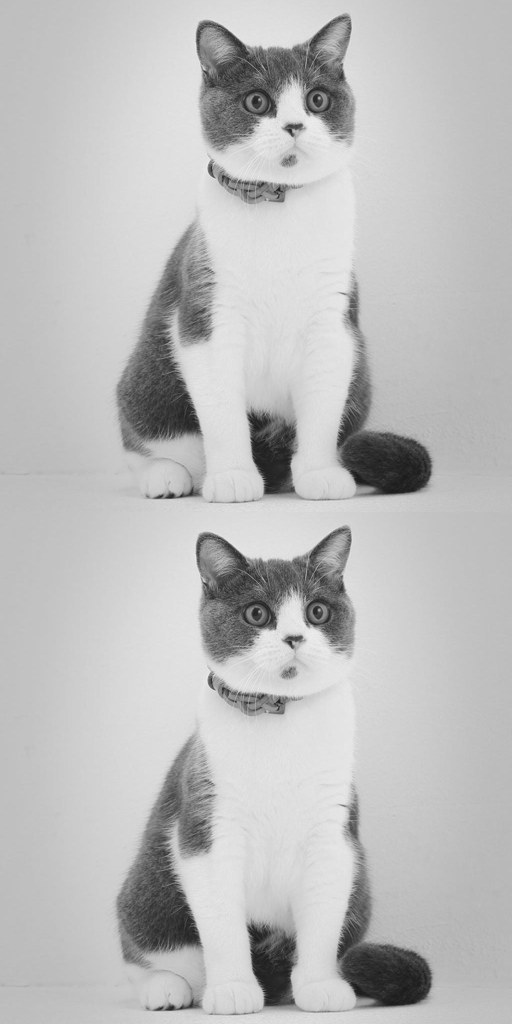

In [56]:
# 竖直重复2次图片
# repeat image 2 times along height (vertical axis)
temp = repeat(np.array(image), 'h w -> (repeat h) w', repeat=2)
print(temp.shape)
Image.fromarray(temp)

(512, 1536)


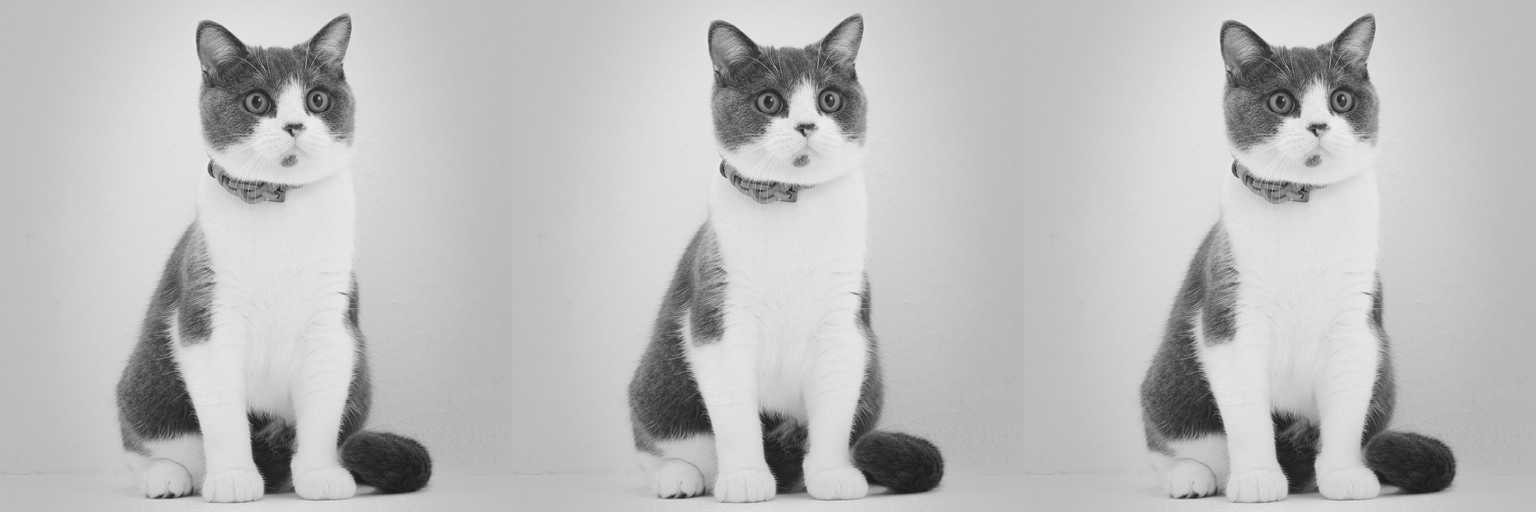

In [58]:
# 水平重复3次
# repeat image 3 time along width
temp = repeat(np.array(image), 'h w -> h (w3 w)', w3=3)
print(temp.shape)
Image.fromarray(temp)

(1024, 1536)


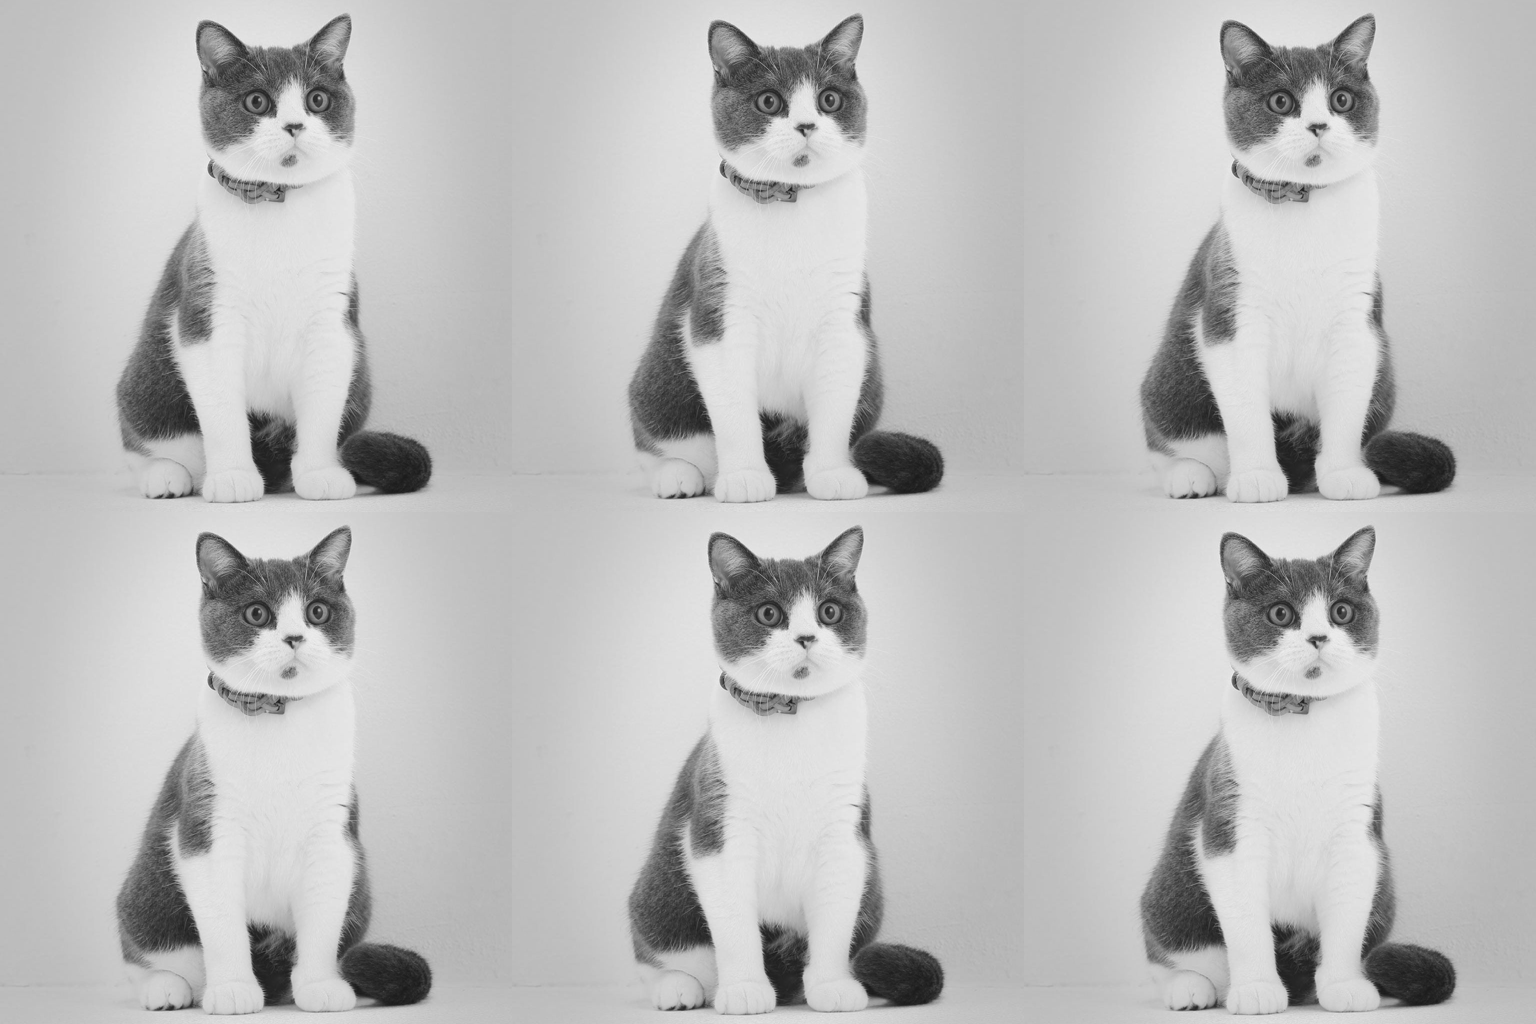

In [59]:
# 竖直重复2次,水平重复3次
# repeat image 2 time along height and 3 times along width
temp = repeat(np.array(image), 'h w -> (h2 h) (w3 w)', h2=2, w3=3)
print(temp.shape)
Image.fromarray(temp)

(1024, 1024)


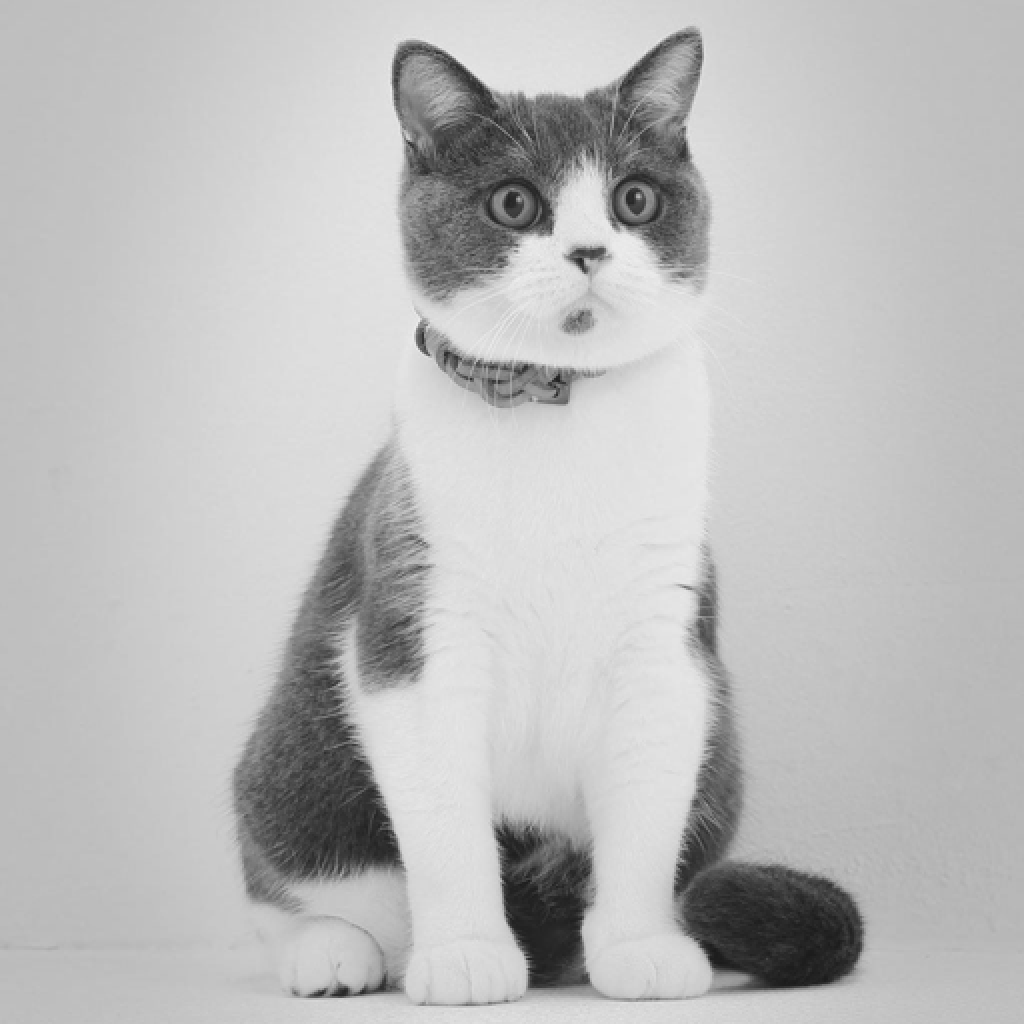

In [60]:
# 每个像素值重复为2x2大小,宽高翻倍
# convert each pixel to a small square 2x2. Upsample image by 2x
temp = repeat(np.array(image), 'h w -> (h h2) (w w2)', h2=2, w2=2)
print(temp.shape)
Image.fromarray(temp)

(256, 256)


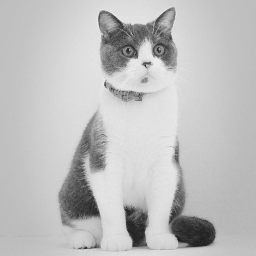

In [62]:
# pixelate image first by downsampling by 2x
downsampled = reduce(np.array(image), '(h h2) (w w2) -> h w', 'max', h2=2, w2=2)
print(downsampled.shape)
Image.fromarray(downsampled)


(512, 512)


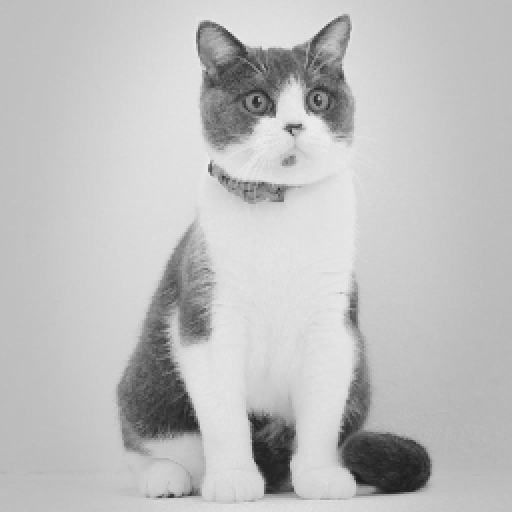

In [64]:
# then upsampling
temp = repeat(downsampled, 'h w -> (h h2) (w w2)', h2=2, w2=2)
print(temp.shape)
Image.fromarray(temp)

(256, 256)


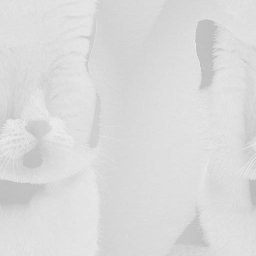

In [66]:
# 错误示例, h2 w2 在前面,然后缩减 h2 w2
temp = reduce(np.array(image), "(h2 h) (w2 w) -> h w", 'max', h2=2, w2=2)
print(temp.shape)
Image.fromarray(temp)

(512, 512)
(256, 256) (256, 256) (256, 256) (256, 256)
(256, 256, 4)
(256, 256)


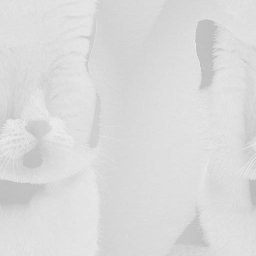

In [68]:
# 相当于将图片分为左上,右上,左下,右下四个部分,然后去对应位置的最大值
temp = np.array(image)
print(temp.shape)
lt  = temp[:256, :256]
rt  = temp[:256, 256:]
lb  = temp[256:, :256]
rb  = temp[256:, 256:]
print(lt.shape, rt.shape, lb.shape, rb.shape)
# [256, 256, 4]
temp = np.stack((lt, rt, lb, rb), axis=2)
print(temp.shape)
# 取4层的最大值
temp = temp.max(axis=-1)
print(temp.shape)
Image.fromarray(temp)